In [ ]:
from datetime import datetime
from sys import platform
import random

import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from face_dataset import FaceDataset

if platform == "linux":
    data_dir = '/home/tuts/Downloads/lfw/lfw_funneled'
else:
    data_dir = '/Users/arturmagalhaes/Downloads/lfw/lfw_funneled'

test_dir = data_dir + '/test'



Loaded 249 total people (with >= 2 photos)


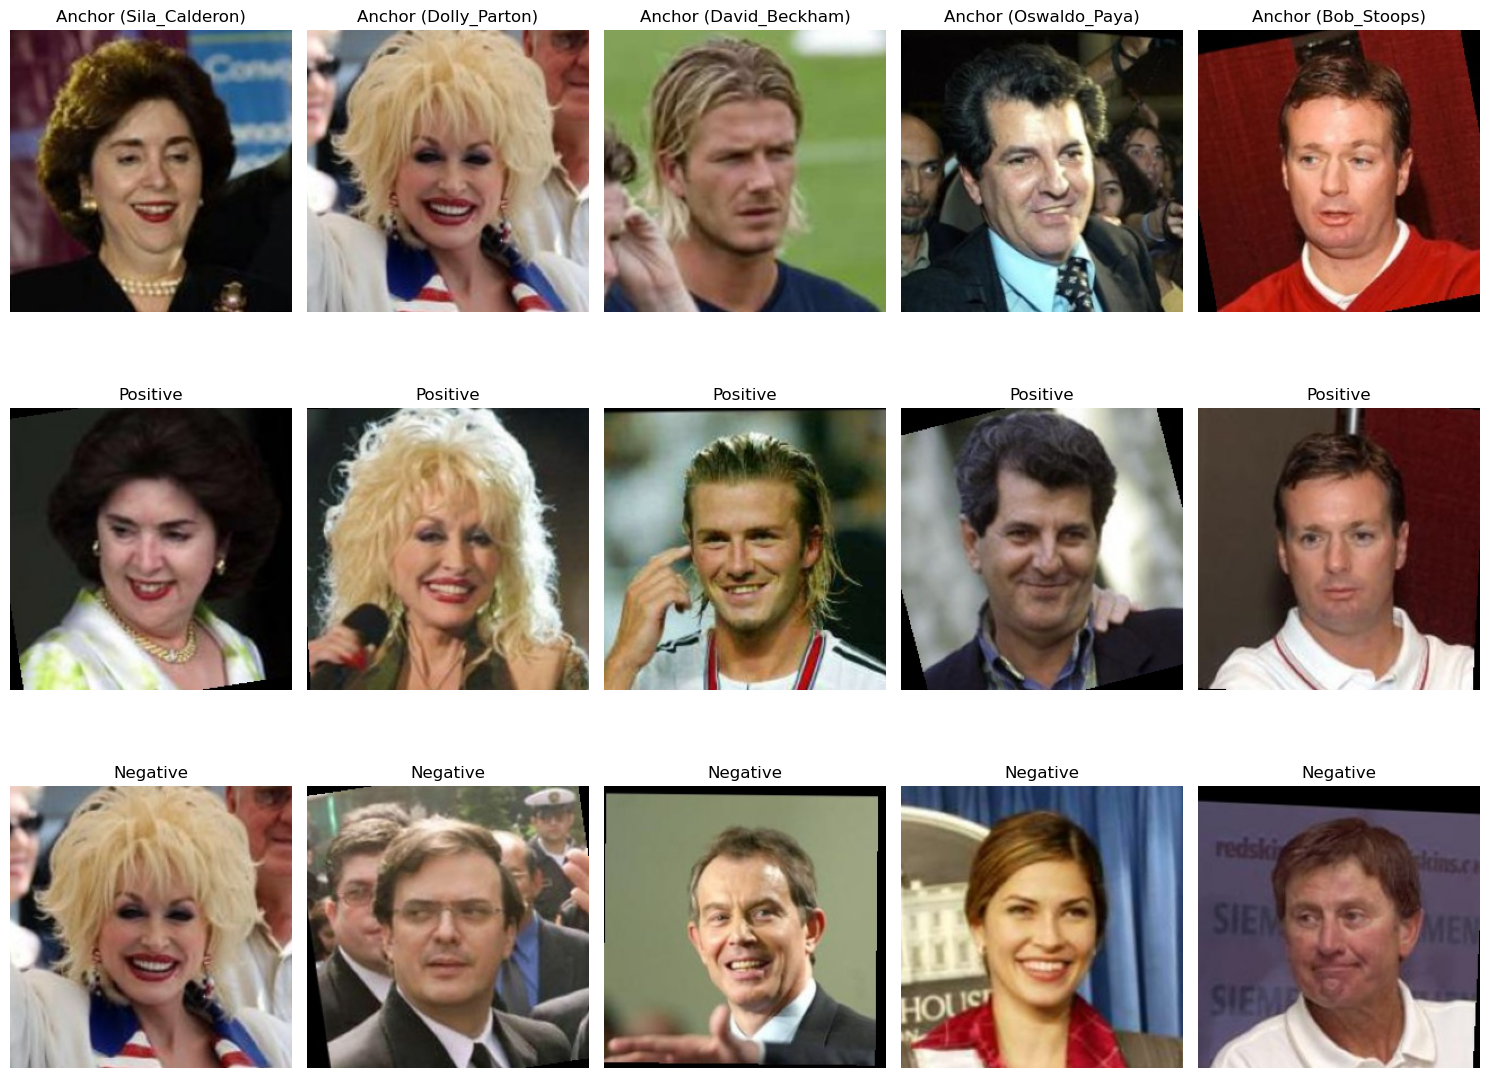

In [2]:
def show_images(dataset, num_samples=5):
    fig, axes = plt.subplots(3, num_samples, figsize=(num_samples*3, 12))
    
    # Handle single sample case
    if num_samples == 1:
        axes = axes.reshape(-1, 1)
    
    # Randomly sample indices
    sample_indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for col, dataset_idx in enumerate(sample_indices):
        anchor, positive, negative = dataset[dataset_idx]

        anchor_name = dataset.get_person_name(dataset_idx)
        
        # Anchor (top row)
        axes[0, col].imshow(to_pil_image(anchor))
        axes[0, col].set_title(f'Anchor ({anchor_name})')
        axes[0, col].axis('off')
        
        # Positive (middle row)
        axes[1, col].imshow(to_pil_image(positive))
        axes[1, col].set_title('Positive')
        axes[1, col].axis('off')
        
        # Negative (bottom row)
        axes[2, col].imshow(to_pil_image(negative))
        axes[2, col].set_title('Negative')
        axes[2, col].axis('off')
    
    plt.tight_layout()
    plt.show()

dataset = FaceDataset(data_dir=test_dir)
show_images(dataset)

In [3]:
from losses import TripletLoss
    
loss = TripletLoss()

In [4]:
random_sample = dataset[42]
len(random_sample)

3

In [5]:
test_loss = TripletLoss()
test_loss(random_sample[0], random_sample[1], random_sample[2])

tensor(1.3786)

In [6]:
def create_transforms():
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    return train_transforms, val_transform

train_transforms, val_transform = create_transforms()

In [7]:
from face_embedding_cnn import FaceEmbeddingCNN

In [8]:
model = FaceEmbeddingCNN()
model

FaceEmbeddingCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=50176, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
)

In [9]:
test_img = val_transform(to_pil_image(random_sample[0]))
model(test_img).shape

torch.Size([1, 512])

In [10]:
from face_embedding_trainer import FaceEmbeddingTrainer

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f'Current device = {device}')

Current device = cuda


In [12]:
if torch.cuda.is_available():
    model.to('cuda')

In [15]:
today = datetime.now().strftime("%Y-%m-%d-%H-%M")

lr = 0.001
weight_decay = 1e-4
epochs = 500
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

train_data_dir = data_dir + '/train'
val_data_dir = data_dir + '/val'

train_dataset = FaceDataset(train_data_dir, transform=train_transforms)
val_dataset = FaceDataset(val_data_dir, transform=val_transform)

Loaded 1172 total people (with >= 2 photos)
Loaded 259 total people (with >= 2 photos)


In [16]:
train_subset_size = int(0.99 * len(train_dataset))
remaining_size = len(train_dataset) - train_subset_size
train_subset_dataset, _ = random_split(train_dataset, [train_subset_size, remaining_size])

val_subset_size = int(0.99 * len(val_dataset))
remaining_size = len(val_dataset) - val_subset_size
val_subset_dataset, _ = random_split(val_dataset, [val_subset_size, remaining_size])

print(f'Length of train subset dataset = {len(train_subset_dataset)}')
print(f'Length of val subset dataset = {len(val_subset_dataset)}')

Length of train subset dataset = 1160
Length of val subset dataset = 256


In [ ]:
def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

In [ ]:
load_from_checkpoint = False
if load_from_checkpoint:
    model, optimizer, epochs, loss = load_model(model, optimizer, f'model/{today}-e{epochs}.pth')

In [ ]:
batch_size = 32
num_workers = 4
# Full dataset
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Subset dataset
train_loader = DataLoader(train_subset_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_subset_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

trainer = FaceEmbeddingTrainer(model, train_loader, val_loader, loss, device=device)

In [18]:
def train(trainer, epochs=1):
    best_val_loss = float('inf')

    for epoch in range(epochs):
        train_loss = trainer.train_epoch(optimizer, epoch)

        val_loss, accuracy = trainer.validate(epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trainer.writer.add_text('Best_Model', f'Epoch {epoch}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}', epoch)

        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    trainer.writer.close()

train(trainer, epochs=epochs)

Size of train loader dataset = 1160
Started training epoch...
Loading batch 0
Loading batch 1
Loading batch 2
Loading batch 3
Loading batch 4
Loading batch 5
Loading batch 6
Loading batch 7
Loading batch 8
Loading batch 9
Loading batch 10
Loading batch 11
Loading batch 12
Loading batch 13
Loading batch 14
Loading batch 15
Loading batch 16
Loading batch 17
Loading batch 18
Loading batch 19
Loading batch 20
Loading batch 21
Loading batch 22
Loading batch 23
Loading batch 24
Loading batch 25
Loading batch 26
Loading batch 27
Loading batch 28
Loading batch 29
Loading batch 30
Loading batch 31
Loading batch 32
Loading batch 33
Loading batch 34
Loading batch 35
Loading batch 36
Finished training epoch...
Size of val loader dataset = 256
Starting validation step...
Loading batch 0
Loading batch 1
Loading batch 2
Loading batch 3
Loading batch 4
Loading batch 5
Loading batch 6
Loading batch 7
Finished validation step...
Epoch 0: Train Loss: 0.4983, Val Loss: 0.4861
Size of train loader dataset 

KeyboardInterrupt: 

In [22]:
# tensorboard --logdir=runs/face_embedding --port 6006

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [19]:
torch.save({
      'epoch': 208,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
  }, f'model/{today}-e{208}.pth')

In [20]:
from face_dataset import SimpleFaceDataset
from face_evaluator import split_dataset_for_evaluation

eval_data_dir = data_dir + '/test'

eval_dataset = SimpleFaceDataset(
        data_dir=eval_data_dir,
        transform=val_transform
    )

Loading images from /home/tuts/Downloads/lfw/lfw_funneled/test
Loaded 1775 images from 863 people


In [21]:
gallery_dataset, query_dataset = split_dataset_for_evaluation(
        eval_dataset,
        gallery_images_per_person=2,  # 2 images per person in gallery
        random_seed=42
    )

Splitting dataset for evaluation:
Gallery images per person: 2
Gallery set: 266 images
Query set: 663 images
People in evaluation: 863 total


In [22]:
gallery_loader = DataLoader(
        gallery_dataset,
        batch_size=batch_size,
        shuffle=False,  # Don't shuffle for consistent results
        num_workers=2
    )

query_loader = DataLoader(
    query_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [23]:
from face_evaluator import FaceRecognitionEvaluator


evaluator = FaceRecognitionEvaluator(model=model, device=device)

results = evaluator.evaluate_recognition(
    gallery_loader=gallery_loader,
    query_loader=query_loader,
    k_values=[1, 3, 5, 10],  # Top-1, top-3, top-5, top-10
    metric='cosine'  # Can also try 'euclidean'
)

Extracting embeddings from 266 images...
Extracted 266 embeddings of dimension 512
Extracting embeddings from 663 images...
  Processed 10/21 batches
  Processed 20/21 batches
Extracted 663 embeddings of dimension 512

Gallery: 266 embeddings from 133 people
Query: 663 embeddings from 133 people

Computing cosine similarities...

Evaluating top-k accuracies...


In [24]:
for metric, value in results.items():
        k = metric.split('_')[1]  # Extract k from 'top_k_accuracy'
        print(f"Top-{k} Accuracy: {value:.4f} ({value*100:.2f}%)")

top1_acc = results['top_1_accuracy']
top5_acc = results['top_5_accuracy']

Top-1 Accuracy: 0.1207 (12.07%)
Top-3 Accuracy: 0.2670 (26.70%)
Top-5 Accuracy: 0.3725 (37.25%)
Top-10 Accuracy: 0.5189 (51.89%)


In [25]:
def compare_similarity_metrics(model, gallery_loader, query_loader, device):
    """
    Compare cosine vs euclidean similarity metrics.
    """
    print("\n" + "="*50)
    print(" Compare similarity metrics")
    print("="*50)

    evaluator = FaceRecognitionEvaluator(model=model, device=device)

    metrics = ['cosine', 'euclidean']
    comparison_results = {}

    for metric in metrics:
        print(f"\n--- Using {metric.upper()} similarity ---")
        results = evaluator.evaluate_recognition(
            gallery_loader=gallery_loader,
            query_loader=query_loader,
            k_values=[1, 5],
            metric=metric
        )
        comparison_results[metric] = results

    # Compare results
    print(f"\n Metric comparison:")
    print(f"{'Metric':<12} {'Top-1':<8} {'Top-5':<8}")
    print("-" * 30)

    for metric, results in comparison_results.items():
        top1 = results['top_1_accuracy']
        top5 = results['top_5_accuracy']
        print(f"{metric:<12} {top1:.4f}   {top5:.4f}")

    return comparison_results

In [26]:
compare_similarity_metrics(model, gallery_loader, query_loader, device)


 Compare similarity metrics

--- Using COSINE similarity ---
Extracting embeddings from 266 images...
Extracted 266 embeddings of dimension 512
Extracting embeddings from 663 images...
  Processed 10/21 batches
  Processed 20/21 batches
Extracted 663 embeddings of dimension 512

Gallery: 266 embeddings from 133 people
Query: 663 embeddings from 133 people

Computing cosine similarities...

Evaluating top-k accuracies...

--- Using EUCLIDEAN similarity ---
Extracting embeddings from 266 images...
Extracted 266 embeddings of dimension 512
Extracting embeddings from 663 images...
  Processed 10/21 batches
  Processed 20/21 batches
Extracted 663 embeddings of dimension 512

Gallery: 266 embeddings from 133 people
Query: 663 embeddings from 133 people

Computing euclidean similarities...

Evaluating top-k accuracies...

 Metric comparison:
Metric       Top-1    Top-5   
------------------------------
cosine       0.1207   0.3725
euclidean    0.1207   0.3725


{'cosine': {'top_1_accuracy': 0.12066365007541478,
  'top_5_accuracy': 0.37254901960784315},
 'euclidean': {'top_1_accuracy': 0.12066365007541478,
  'top_5_accuracy': 0.37254901960784315}}